In [2]:
import torch
from torch import nn
import torchvision
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt

In [4]:
img_size=32
channels=1
batch_size=32

In [5]:
dataset=torchvision.datasets.MNIST(
    './',
    train=True,
    download=True,
    transform=transforms.Compose(
        [transforms.Resize(img_size),transforms.ToTensor(),transforms.Normalize([0.5],[0.5])]
    
    ) 
)
dataloader=torch.utils.data.DataLoader(dataset,batch_size=batch_size,drop_last=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 97225152.17it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 144381041.51it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 24987684.44it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 7941029.08it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [6]:
n_class=10
class Generator(nn.Module):
    def __init__(self,z_dim):
        super().__init__()
        self.z_dim=z_dim
        self.channels=64
        def block(in_c,out_c,activation='relu'):
            layers=[]
            layers.append(nn.Upsample(scale_factor=2))
            layers.append(nn.Conv2d(in_c,out_c,5,1,2))
            if activation=='relu':
                layers.append(nn.BatchNorm2d(out_c,0.8))
                layers.append(nn.LeakyReLU(0.2))
            else:
                layers.append(nn.Tanh())
            return nn.Sequential(*layers)
        self.embe=nn.Sequential(nn.Embedding(n_class,z_dim))
        #(batch_size,z_dim,z_dim)
        self.img_size=img_size//8
        self.fc=nn.Sequential(
            nn.Flatten(),
            nn.Linear(z_dim*z_dim,self.img_size*self.img_size*self.channels)
        )
        self.conv=nn.Sequential(
            *block(self.channels,self.channels//4),
            *block(self.channels//4,self.channels//16),
            *block(self.channels//16,self.channels//64,'tanh'),
        
        )
    def forward(self,x,labels):
        label=self.embe(labels)
        x=x.unsqueeze(2)
        input_x=torch.bmm(x,label)
        input_x=self.fc(input_x)
        input_x=input_x.view((-1,self.channels,self.img_size,self.img_size))
        return self.conv(input_x)
        #print(input_x.shape,label.shape,x.shape)
        #return 0
            
g=Generator(30)
g(torch.randn((32,30)),torch.LongTensor(np.random.randint(0,10,(32,1)))).shape

torch.Size([32, 1, 32, 32])

In [11]:
class Discriminator(nn.Module):
    def __init__(self,):
        super().__init__()
        self.img_size=32
        self.channels=1
        def block(in_c,out_c):
            return nn.Sequential(
                nn.Conv2d(in_c,out_c,5,2,2),
                nn.BatchNorm2d(out_c,0.8),
                nn.LeakyReLU(0.2),
                nn.Dropout2d(0.25),
            )
        in_c_list=[1,4,16]
        out_c_list=[4,16,64]
        self.dis=nn.Sequential(
            *block(1,4),
            *block(4,16),
            *block(16,64),
            nn.Flatten(),
        )
        #(bs,64,img_size/8,img_size/8)
        self.img_size=img_size//8
        input_size=64*self.img_size*self.img_size
        self.fc1=nn.Sequential(nn.Linear(input_size,1))#使用torch.nn.BCEWithLogitsLoss()
        self.fc2=nn.Sequential(nn.Linear(input_size,n_class))#使用交叉熵损失不用加softmax
    def forward(self,x):
        features=self.dis(x)
        return self.fc1(features),self.fc2(features)
d=Discriminator()
d_input_shape=(batch_size,channels,img_size,img_size)
y1,y2=d(torch.randn(d_input_shape))
y1.shape,y2.shape

(torch.Size([32, 1]), torch.Size([32, 10]))

In [12]:
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
z_dim=30
lr=0.0002
b1=0.5
b2=0.999
epochs=50

In [13]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)
        

G=Generator(z_dim).to(device)
D=Discriminator().to(device)
G.apply(weights_init_normal)
D.apply(weights_init_normal)

dis_loss = torch.nn.BCEWithLogitsLoss()
rec_loss = torch.nn.CrossEntropyLoss()
optimizer_G = torch.optim.Adam(G.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(D.parameters(), lr=lr, betas=(b1, b2))



In [10]:
cuda=True if torch.cuda.is_available() else False
FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if cuda else torch.LongTensor

def show(imgs,figsize=(6,6)):
    plt.figure(figsize=figsize)
    imgs=torchvision.utils.make_grid(imgs,nrow=10,padding=2)     
    imgs=imgs.detach().cpu().numpy().transpose(1, 2, 0)
    plt.imshow(imgs*0.5+0.5)
    plt.show()
def draw():
    static_label=LongTensor(np.array([num for _ in range(n_class) for num in range(n_class)])).view(-1,1)
    noise=FloatTensor(np.random.randn(n_class*n_class,z_dim))
    #print(static_label.shape)
    fake_imgs=G(noise,static_label)
    show(fake_imgs,(6,6))


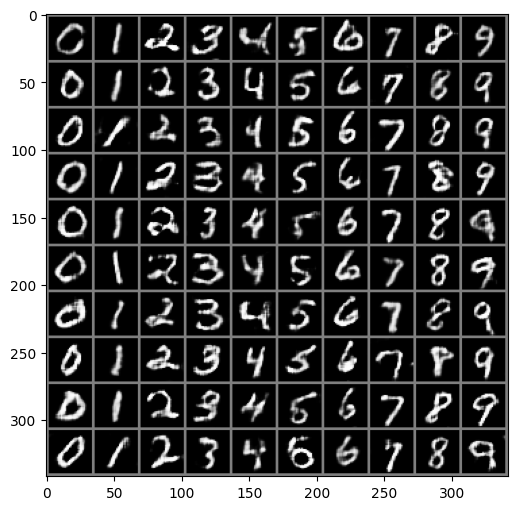

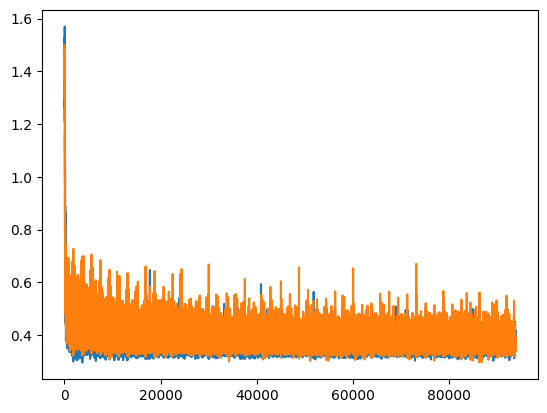

[Epoch 49/50] [Batch 1826/1875] [D loss: 0.335019, acc: 100%] [G loss: 0.428326]
[Epoch 49/50] [Batch 1827/1875] [D loss: 0.383714, acc: 98%] [G loss: 0.341071]
[Epoch 49/50] [Batch 1828/1875] [D loss: 0.371494, acc: 98%] [G loss: 0.346243]
[Epoch 49/50] [Batch 1829/1875] [D loss: 0.360205, acc: 100%] [G loss: 0.344879]
[Epoch 49/50] [Batch 1830/1875] [D loss: 0.347482, acc: 100%] [G loss: 0.345295]
[Epoch 49/50] [Batch 1831/1875] [D loss: 0.355642, acc: 100%] [G loss: 0.337772]
[Epoch 49/50] [Batch 1832/1875] [D loss: 0.346659, acc: 100%] [G loss: 0.357428]
[Epoch 49/50] [Batch 1833/1875] [D loss: 0.350022, acc: 100%] [G loss: 0.359835]
[Epoch 49/50] [Batch 1834/1875] [D loss: 0.366203, acc: 98%] [G loss: 0.321434]
[Epoch 49/50] [Batch 1835/1875] [D loss: 0.338262, acc: 100%] [G loss: 0.378214]
[Epoch 49/50] [Batch 1836/1875] [D loss: 0.338969, acc: 100%] [G loss: 0.355599]
[Epoch 49/50] [Batch 1837/1875] [D loss: 0.354286, acc: 98%] [G loss: 0.343061]
[Epoch 49/50] [Batch 1838/1875] 

In [14]:
from IPython.display import clear_output
g_loss_list=[]
d_loss_list=[]
for epoch in range(epochs):
    for i,(imgs,labels) in enumerate(dataloader):
        real_imgs=imgs.to(device)
        labels=labels.to(device)
        
        valid=FloatTensor(np.ones((batch_size,1)))
        fake=FloatTensor(np.zeros((batch_size,1)))
        
        optimizer_G.zero_grad()
        
        noise=FloatTensor(np.random.randn(batch_size,z_dim))
        gen_labels=LongTensor(np.random.randint(0,n_class,(batch_size,1)))
        
        fake_imgs=G(noise,gen_labels)
        
        validity, pred_label = D(fake_imgs)
        g_loss=(dis_loss(validity,valid)+rec_loss(pred_label,gen_labels.squeeze(1)))/2
        
        g_loss.backward()
        optimizer_G.step()
        
        optimizer_D.zero_grad()
        real_dis,real_rec=D(real_imgs)
        d_real_loss=(dis_loss(real_dis,valid)+rec_loss(real_rec,labels))/2
        
        fake_dis,fake_rec=D(fake_imgs.detach())
        d_fake_loss=(dis_loss(fake_dis,fake)+rec_loss(fake_rec,gen_labels.squeeze(1)))/2
        
        d_loss=(d_real_loss+d_fake_loss)/2
        d_loss.backward()
        optimizer_D.step()
        
        pred=torch.cat([real_rec,fake_rec],dim=0).detach().cpu().numpy()
        real=torch.cat([labels,gen_labels.squeeze(1)],dim=0).detach().cpu().numpy()
        d_acc=np.mean(np.argmax(pred,axis=1) == real)
        
        print(
            "[Epoch %d/%d] [Batch %d/%d] [D loss: %f, acc: %d%%] [G loss: %f]"
            % (epoch, epochs, i, len(dataloader), d_loss.item(), 100 * d_acc, g_loss.item())
        )
        g_loss_list.append(g_loss.item())
        d_loss_list.append(d_loss.item())
        batch_done=epoch*len(dataloader)+i
        if batch_done%100==0:
            clear_output()
            draw()
            #show(fake_imgs)
            plt.plot(range(batch_done+1),g_loss_list)
            plt.plot(range(batch_done+1),d_loss_list)
            plt.show()
        

In [ ]:
import argparse
import os
import numpy as np
import math

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

os.makedirs("images", exist_ok=True)

parser = argparse.ArgumentParser()
parser.add_argument("--n_epochs", type=int, default=200, help="number of epochs of training")
parser.add_argument("--batch_size", type=int, default=64, help="size of the batches")
parser.add_argument("--lr", type=float, default=0.0002, help="adam: learning rate")
parser.add_argument("--b1", type=float, default=0.5, help="adam: decay of first order momentum of gradient")
parser.add_argument("--b2", type=float, default=0.999, help="adam: decay of first order momentum of gradient")
parser.add_argument("--n_cpu", type=int, default=8, help="number of cpu threads to use during batch generation")
parser.add_argument("--latent_dim", type=int, default=100, help="dimensionality of the latent space")
parser.add_argument("--n_classes", type=int, default=10, help="number of classes for dataset")
parser.add_argument("--img_size", type=int, default=32, help="size of each image dimension")
parser.add_argument("--channels", type=int, default=1, help="number of image channels")
parser.add_argument("--sample_interval", type=int, default=400, help="interval between image sampling")
opt = parser.parse_args([])
print(opt)

cuda = True if torch.cuda.is_available() else False


def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)


class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.label_emb = nn.Embedding(opt.n_classes, opt.latent_dim)

        self.init_size = opt.img_size // 4  # Initial size before upsampling
        self.l1 = nn.Sequential(nn.Linear(opt.latent_dim, 128 * self.init_size ** 2))

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, opt.channels, 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, noise, labels):
        gen_input = torch.mul(self.label_emb(labels), noise)
        out = self.l1(gen_input)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, bn=True):
            """Returns layers of each discriminator block"""
            block = [nn.Conv2d(in_filters, out_filters, 3, 2, 1), nn.LeakyReLU(0.2, inplace=True), nn.Dropout2d(0.25)]
            if bn:
                block.append(nn.BatchNorm2d(out_filters, 0.8))
            return block

        self.conv_blocks = nn.Sequential(
            *discriminator_block(opt.channels, 16, bn=False),
            *discriminator_block(16, 32),
            *discriminator_block(32, 64),
            *discriminator_block(64, 128),
        )

        # The height and width of downsampled image
        ds_size = opt.img_size // 2 ** 4

        # Output layers
        self.adv_layer = nn.Sequential(nn.Linear(128 * ds_size ** 2, 1), nn.Sigmoid())
        self.aux_layer = nn.Sequential(nn.Linear(128 * ds_size ** 2, opt.n_classes), nn.Softmax())

    def forward(self, img):
        out = self.conv_blocks(img)
        out = out.view(out.shape[0], -1)
        validity = self.adv_layer(out)
        label = self.aux_layer(out)

        return validity, label


# Loss functions
adversarial_loss = torch.nn.BCELoss()
auxiliary_loss = torch.nn.CrossEntropyLoss()

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()
    auxiliary_loss.cuda()

# Initialize weights
generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)

# Configure data loader
os.makedirs("../../data/mnist", exist_ok=True)
dataloader = torch.utils.data.DataLoader(
    datasets.MNIST(
        "../../data/mnist",
        train=True,
        download=True,
        transform=transforms.Compose(
            [transforms.Resize(opt.img_size), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
        ),
    ),
    batch_size=opt.batch_size,
    shuffle=True,
)

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))

FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if cuda else torch.LongTensor


def sample_image(n_row, batches_done):
    """Saves a grid of generated digits ranging from 0 to n_classes"""
    # Sample noise
    z = Variable(FloatTensor(np.random.normal(0, 1, (n_row ** 2, opt.latent_dim))))
    # Get labels ranging from 0 to n_classes for n rows
    labels = np.array([num for _ in range(n_row) for num in range(n_row)])
    labels = Variable(LongTensor(labels))
    gen_imgs = generator(z, labels)
    save_image(gen_imgs.data, "images/%d.png" % batches_done, nrow=n_row, normalize=True)


# ----------
#  Training
# ----------

for epoch in range(opt.n_epochs):
    for i, (imgs, labels) in enumerate(dataloader):

        batch_size = imgs.shape[0]

        # Adversarial ground truths
        valid = Variable(FloatTensor(batch_size, 1).fill_(1.0), requires_grad=False)
        fake = Variable(FloatTensor(batch_size, 1).fill_(0.0), requires_grad=False)

        # Configure input
        real_imgs = Variable(imgs.type(FloatTensor))
        labels = Variable(labels.type(LongTensor))

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()
        # Sample noise and labels as generator input
        z = Variable(FloatTensor(np.random.normal(0, 1, (batch_size, opt.latent_dim))))
        gen_labels = Variable(LongTensor(np.random.randint(0, opt.n_classes, batch_size)))

        # Generate a batch of images
        gen_imgs = generator(z, gen_labels)

        # Loss measures generator's ability to fool the discriminator
        validity, pred_label = discriminator(gen_imgs)
        print(pred_label.shape,gen_labels.shape)
        g_loss = 0.5 * (adversarial_loss(validity, valid) + auxiliary_loss(pred_label, gen_labels))

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Loss for real images
        real_pred, real_aux = discriminator(real_imgs)
        d_real_loss = (adversarial_loss(real_pred, valid) + auxiliary_loss(real_aux, labels)) / 2

        # Loss for fake images
        fake_pred, fake_aux = discriminator(gen_imgs.detach())
        d_fake_loss = (adversarial_loss(fake_pred, fake) + auxiliary_loss(fake_aux, gen_labels)) / 2

        # Total discriminator loss
        d_loss = (d_real_loss + d_fake_loss) / 2

        # Calculate discriminator accuracy
        pred = np.concatenate([real_aux.data.cpu().numpy(), fake_aux.data.cpu().numpy()], axis=0)
        gt = np.concatenate([labels.data.cpu().numpy(), gen_labels.data.cpu().numpy()], axis=0)
        d_acc = np.mean(np.argmax(pred, axis=1) == gt)

        d_loss.backward()
        optimizer_D.step()

        print(
            "[Epoch %d/%d] [Batch %d/%d] [D loss: %f, acc: %d%%] [G loss: %f]"
            % (epoch, opt.n_epochs, i, len(dataloader), d_loss.item(), 100 * d_acc, g_loss.item())
        )
        batches_done = epoch * len(dataloader) + i
        if batches_done % opt.sample_interval == 0:
            sample_image(n_row=10, batches_done=batches_done)
